In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score, roc_curve

import imblearn.over_sampling

from imblearn.over_sampling import SMOTENC

from sklearn.metrics import plot_confusion_matrix



In [92]:
df_behavior = pd.read_csv('envior-USA.csv')
df_health = pd.read_csv('health-USA.csv')
df_big2 = pd.read_csv('USA-data-categorical.csv')
df_big = pd.read_csv('compact-USA.csv')


In [93]:
df_big = df_big.drop(['events_score'],axis=1)
df_big = pd.get_dummies(df_big, columns=['household_size2'])

In [111]:
df_big


,weight,age,"COVID-19 Status_Yes, and I tested positive",Contact w/ COVID_Yes,Travel_Yes,Facemask Use_Not at all,Soap Use_Not at all,Avoided shops_Not at all,Avoided public transport?_Not at all,Avoided working from home?_Not at all,...,large_events_Not at all,employment_status_Unemployed,Preexisting Condition Score,household_size2_1,household_size2_2,household_size2_3,household_size2_4,household_size2_5,household_size2_6,household_size2_7
0,0.907068,33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.878366,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.150452,48,0,0,0,1,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0
3,0.995127,31,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1.354855,69,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32055,4.645645,59,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
32056,1.287069,37,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
32057,0.753059,71,0,0,0,0,0,0,0,0,...,0,0,3,0,1,0,0,0,0,0
32058,1.139877,35,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [94]:
model_types = []
recall_scores = []
AUC_scores = []
F1_scores = []

In [95]:
X = df_big.drop(['COVID-19 Status_Yes, and I tested positive'], axis=1)
y = df_big['COVID-19 Status_Yes, and I tested positive']

In [96]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32055    0
32056    0
32057    0
32058    0
32059    0
Name: COVID-19 Status_Yes, and I tested positive, Length: 32060, dtype: int64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state=42)

In [98]:
#oversampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
not_COVID = X[X['COVID-19 Status_Yes, and I tested positive']==0]
COVID = X[X['COVID-19 Status_Yes, and I tested positive']==1]
# upsample minority
fraud_upsampled = resample(COVID,
                          replace=True, # sample with replacement
                          n_samples=len(not_COVID), # match number in majority class
                          random_state=27) # reproducible results
fraud_upsampled2 = resample(COVID,
                          replace=True, # sample with replacement
                          n_samples=len(not_COVID)*2, # double number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([not_COVID, fraud_upsampled])
upsampled2 = pd.concat([not_COVID, fraud_upsampled2])

# check new class counts
upsampled['COVID-19 Status_Yes, and I tested positive'].value_counts()
# trying logistic regression again with the balanced dataset
y_train_u = upsampled['COVID-19 Status_Yes, and I tested positive']
X_train_u = upsampled.drop('COVID-19 Status_Yes, and I tested positive', axis=1)
y_train_u2 = upsampled2['COVID-19 Status_Yes, and I tested positive']
X_train_u2 = upsampled2.drop('COVID-19 Status_Yes, and I tested positive', axis=1)

In [99]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in C:
    #regular logistic
    logit = LogisticRegression(C = i)
    logit.fit(X_train, y_train)
    logit_pred = logit.predict(X_test)
    model_types.append('Initial Data, C =' + str(i))
    recall_scores.append((100*recall_score(y_test, logit_pred)))
    AUC_scores.append(100*roc_auc_score(y_test, logit.predict_proba(X_test)[:,1]))
    F1_scores.append(100*f1_score(y_test, logit_pred))

for i in C:
    #SMOTE
    smote = SMOTENC([1],random_state = 101)
    X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)
    lr_smote = LogisticRegression(solver='liblinear', C = i) 
    lr_smote.fit(X_tr_smote, y_tr_smote)
    lr_smote_pred = lr_smote.predict(X_test)
    model_types.append('SMOTE Data, C = '+ str(i))
    recall_scores.append((100*recall_score(y_test, lr_smote.predict(X_test))))
    AUC_scores.append(100*roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1]))
    F1_scores.append(100*f1_score(y_test, lr_smote_pred))

    
for i in C:
    #Oversampled
    logit2 = LogisticRegression(C = i)
    logit2.fit(X_train_u, y_train_u)
    logit2_pred = logit2.predict(X_test)
    model_types.append('Oversampled Data, C ='+ str(i))
    recall_scores.append((100*recall_score(y_test, logit2_pred)))
    AUC_scores.append(100*roc_auc_score(y_test, logit2.predict_proba(X_test)[:,1]))
    F1_scores.append(100*f1_score(y_test, logit2_pred))

for i in C:
    #Oversampled
    logit2 = LogisticRegression(C = i)
    logit2.fit(X_train_u2, y_train_u2)
    logit2_pred = logit2.predict(X_test)
    model_types.append('Oversampled Data, C ='+ str(i))
    recall_scores.append((100*recall_score(y_test, logit2_pred)))
    AUC_scores.append(100*roc_auc_score(y_test, logit2.predict_proba(X_test)[:,1]))
    F1_scores.append(100*f1_score(y_test, logit2_pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [100]:

# Calling DataFrame after zipping both lists, with columns specified 
df = pd.DataFrame(list(zip(model_types, recall_scores, AUC_scores, F1_scores)), columns =['Model Type', 'recall_scores', 'AUC Score', 'F1_score']) 
print(df) 
for_plot = df.drop([3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20])


                    Model Type  recall_scores  AUC Score   F1_score
0        Initial Data, C =0.01       4.878049  92.137774   9.302326
1         Initial Data, C =0.1      21.951220  92.589516  31.578947
2           Initial Data, C =1      39.024390  92.749922  47.058824
3          Initial Data, C =10      39.024390  92.623971  46.376812
4         Initial Data, C =100      39.024390  92.554678  47.058824
5        Initial Data, C =1000      39.024390  92.592961  47.058824
6       Initial Data, C =10000      39.024390  92.576499  46.376812
7         SMOTE Data, C = 0.01      73.170732  91.594535  12.875536
8          SMOTE Data, C = 0.1      70.731707  90.371003  15.890411
9            SMOTE Data, C = 1      68.292683  89.433064  14.893617
10          SMOTE Data, C = 10      68.292683  88.863792  14.893617
11         SMOTE Data, C = 100      68.292683  88.582793  14.775726
12        SMOTE Data, C = 1000      68.292683  88.557526  14.775726
13       SMOTE Data, C = 10000      68.292683  8

In [101]:
for_plot

,Model Type,recall_scores,AUC Score,F1_score
0,"Initial Data, C =0.01",4.878049,92.137774,9.302326
1,"Initial Data, C =0.1",21.951220,92.589516,31.578947
2,"Initial Data, C =1",39.024390,92.749922,47.058824
7,"SMOTE Data, C = 0.01",73.170732,91.594535,12.875536
14,"Oversampled Data, C =0.01",75.609756,91.323872,11.946050
21,"Oversampled Data, C =0.01",80.487805,90.950994,5.779335
22,"Oversampled Data, C =0.1",80.487805,90.280654,5.754141
23,"Oversampled Data, C =1",80.487805,90.388996,5.789474
24,"Oversampled Data, C =10",80.487805,90.268404,5.679862
25,"Oversampled Data, C =100",80.487805,90.222464,5.709343


Text(0, 0.5, 'Recall Score')

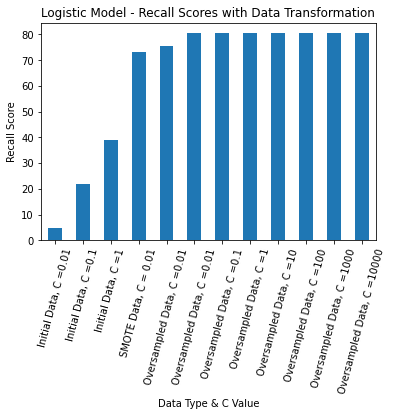

In [102]:
for_plot.plot.bar("Model Type", "recall_scores", rot=75, legend=False)
plt.title("Logistic Model - Recall Scores with Data Transformation")
plt.xlabel("Data Type & C Value")
plt.ylabel("Recall Score")

In [ ]:
smote = SMOTENC([1],random_state = 101)
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)
lr_smote = LogisticRegression(solver='liblinear', C = 0.1) 
lr_smote.fit(X_tr_smote, y_tr_smote)


In [105]:
logit2 = LogisticRegression(C =0.01)
logit2.fit(X_train_u2, y_train_u2)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01)

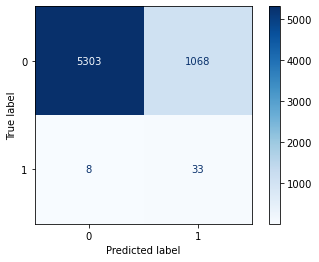

In [106]:
plot_confusion_matrix(logit2, X_test, y_test,cmap=plt.cm.Blues) 

In [107]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logit2.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)


In [108]:
importances['Attribute']= importances['Attribute'].replace({'Contact w/ COVID_Yes	': 'Close contact with someone with COVID-19', 
                                  'Travel_Yes': 'Travel to area with high case rate', 
                                  'guests_Not at all': 'Often hosted guests', 
                                  'Soap Use_Not at all': 'Did not wash hands with soap',
                                 'large_events_Not at all': 'Attended large events',
                                 'employment_status_Part time employment': 'Employed part time',
                                 'gender_Male': 'Male',
                                 'household_size2_5': 'Household Size: 5',
                                 'gender_Female': 'Female',
                                 'household_size2_6': 'Household Size: 6',
                                 'employment_status_Not working': 'Unemployed',
                                 'Avoided public transport?_Not at all': 'Did not avoid public transport',
                                 'small_events_Not at all': 'Attended small events',
                                 'Avoided working from home?_Not at all': 'Did not work from home',
                                 'Facemask Use_Not at all': 'Did not use facemask in public settings'})



In [109]:
importances

,Attribute,Importance
2,Contact w/ COVID_Yes,3.479882
3,Travel to area with high case rate,2.211174
17,Often hosted guests,0.894650
10,Male,0.760321
15,Employed part time,0.613428
26,household_size2_4,0.489748
21,employment_status_Unemployed,0.465575
20,Attended large events,0.461649
25,household_size2_3,0.368728
5,Did not wash hands with soap,0.350033


                                  Attribute  Importance
2                      Contact w/ COVID_Yes    3.479882
3        Travel to area with high case rate    2.211174
17                      Often hosted guests    0.894650
10                                     Male    0.760321
15                       Employed part time    0.613428
13                               Unemployed   -0.709685
7            Did not avoid public transport   -0.941982
18                    Attended small events   -0.958881
8                    Did not work from home   -1.518347
4   Did not use facemask in public settings   -1.746482


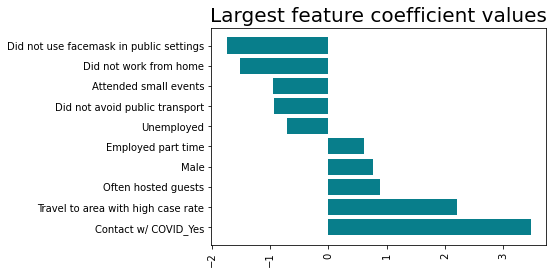

In [110]:
mask = abs(importances['Importance']) > 0.5
importances2 = importances[mask]
print(importances2)
plt.barh(y=importances2['Attribute'], width=importances2['Importance'], color='#087E8B')
plt.title('Largest feature coefficient values', size=20)
plt.xticks(rotation='vertical')
plt.show()